In [1]:
# Train the ML model
%load_ext autoreload
%autoreload 2
from models import extendedCED, Encoder
# from utils import load_model_data_new, normalize_params
from utils import plot_loss, encoder_files_to_tensors
import time
import glob
import tensorflow as tf
from tensorflow import keras
import yaml
import os
import numpy as np
from datetime import datetime
import argparse
import matplotlib.pyplot as plt
import matplotlib as mpl


2022-09-16 13:21:00.359315: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-16 13:21:00.362237: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiliakis/install/lib:/usr/lib/x86_64-linux-gnu
2022-09-16 13:21:00.362245: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Initialize parameters
data_dir = '/eos/kiliakis/tomo_data/datasets'
timestamp = datetime.now().strftime("%Y_%m_%d_%H-%M-%S")

# Data specific
IMG_OUTPUT_SIZE = 128
BUFFER_SIZE = 1000
BATCH_SIZE = 32  # 8
latent_dim = 7  # 6 + the new VrfSPS
# additional_latent_dim = 1

# Train specific
train_cfg = {
    'epochs': 5,
    'dense_layers': [64, latent_dim],
    'filters': [32, 32],
    'cropping': [8, 0],
    'kernel_size': 3,
    'strides': [2,2],
    'activation': 'relu',
    'pooling': None,
    'pooling_size': [0, 0],
    'pooling_strides': [1, 1],
    'pooling_padding': 'valid',
    'dropout': 0.2,
    'loss': 'mse',
    'lr': 1e-3,
    'dataset%': 0.1
}

# Keep only a small percentage of the entire dataset
# for faster testing.
# dataset_keep_percent = 0.1
# cnn_filters = [32, 64, 128, 256, 512, 1024]
# cnn_filters = [32]


In [3]:
# Initialize directories
trial_dir = os.path.join('./trials/', timestamp)
weights_dir = os.path.join(trial_dir, 'weights')
plots_dir = os.path.join(trial_dir, 'plots')

# Initialize train/ test / validation paths
ML_dir = os.path.join(data_dir, 'ML_data')
TRAINING_PATH = os.path.join(ML_dir, 'TRAINING')
VALIDATION_PATH = os.path.join(ML_dir, 'VALIDATION')
assert os.path.exists(TRAINING_PATH)
assert os.path.exists(VALIDATION_PATH)

# create the directory to store the results
os.makedirs(trial_dir, exist_ok=True)
os.makedirs(weights_dir, exist_ok=False)
os.makedirs(plots_dir, exist_ok=False)

# Initialize GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
device_to_use = 0

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        tf.config.experimental.set_memory_growth(gpus[device_to_use], True)
        tf.config.experimental.set_virtual_device_configuration(
            gpus[device_to_use],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=12*1024)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(
            logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print('No GPU available, using the CPU')


No GPU available, using the CPU


2022-09-16 13:21:01.874083: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiliakis/install/lib:/usr/lib/x86_64-linux-gnu
2022-09-16 13:21:01.874114: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-16 13:21:01.874133: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sy153): /proc/driver/nvidia/version does not exist


In [4]:
# Create the datasets
# First the training data
files = glob.glob(TRAINING_PATH + '/*.pk')
files = files[:int(len(files) * train_cfg['dataset%'])]

# Shuffle them
np.random.shuffle(files)
# read input, divide in features/ label, create tensors
x_train, y_train = encoder_files_to_tensors(files)

# Then the validation data
files = glob.glob(VALIDATION_PATH + '/*.pk')
files = files[:int(len(files) * train_cfg['dataset%'])]

# Shuffle them
np.random.shuffle(files)
# read input, divide in features/ label, create tensors
x_valid, y_valid = encoder_files_to_tensors(files)


2022-09-16 13:21:02.217736: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
print(tf.reduce_mean(y_train, 0))
print(tf.math.reduce_std(y_train, 0))

tf.Tensor(
[0.01258258 0.00792794 0.4120871  0.96290886 0.09336604 0.9298805
 0.08374285], shape=(7,), dtype=float32)
tf.Tensor(
[0.58280116 0.5655346  0.8378443  2.2143328  0.80448955 1.082536
 0.9065396 ], shape=(7,), dtype=float32)


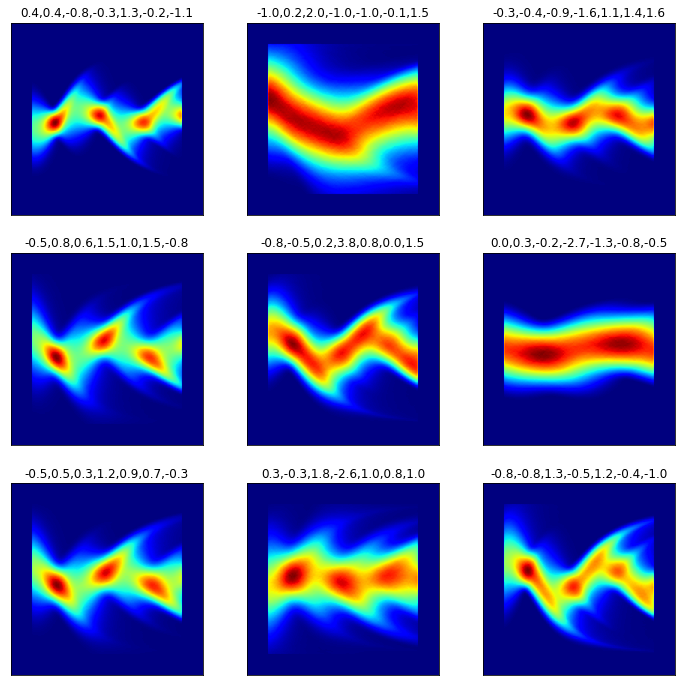

In [6]:
%matplotlib inline
# plot some of the outputs

nrows = 3
# Get nrows * nrows random images
sample = np.random.choice(np.arange(len(x_train)),
                          size=nrows * nrows, replace=False)

samples_X = tf.gather(x_train, sample)
samples_y = tf.gather(y_train, sample)

# Create 3x3 grid of figures
fig, axes = plt.subplots(ncols=nrows, nrows=nrows, figsize=(12, 12))
axes = np.ravel(axes)
for i in range(len(axes)):
    ax = axes[i]
    ax.set_xticks([])
    ax.set_yticks([])
    # show the image
    ax.imshow(samples_X[i], cmap='jet')
    # Set the label
    title = ','.join([f'{num:.1f}' for num in samples_y[i]])
    ax.set_title(f'{title}')


In [8]:
# Model instantiation
input_shape = (IMG_OUTPUT_SIZE, IMG_OUTPUT_SIZE, 1)

encoder = Encoder(input_shape=input_shape, **train_cfg)

print(encoder.model.summary())



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Crop (Cropping2D)           (None, 112, 112, 1)       0         
                                                                 
 CNN_1 (Conv2D)              (None, 55, 55, 32)        320       
                                                                 
 CNN_2 (Conv2D)              (None, 27, 27, 32)        9248      
                                                                 
 Flatten (Flatten)           (None, 23328)             0         
                                                                 
 Dense_1 (Dense)             (None, 64)                1493056   
                                                                 
 Dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 Output (Dense)              (None, 7)                

In [9]:
# Train the encoder

# callbacks, save the best model, and early stop if no improvement in val_loss
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=5, restore_best_weights=True)
save_best = keras.callbacks.ModelCheckpoint(filepath=os.path.join(weights_dir, 'encoder'),
                                            monitor='val_loss', save_best_only=True)


In [11]:
start_time = time.time()
history = encoder.model.fit(
    x_train, y_train, epochs=train_cfg['epochs'],
    validation_data=(x_valid, y_valid), batch_size=BATCH_SIZE,
    callbacks=[stop_early, save_best])

total_time = time.time() - start_time


Epoch 1/5
19/21 [==========================>...] - ETA: 0s - loss: 1.8132

INFO:tensorflow:Assets written to: ./trials/2022_09_16_13-21-01/weights/encoder/assets


INFO:tensorflow:Assets written to: ./trials/2022_09_16_13-21-01/weights/encoder/assets


21/21 [==============================] - 2s 87ms/step - loss: 1.7588 - val_loss: 1.4393
Epoch 2/5
19/21 [==========================>...] - ETA: 0s - loss: 1.3038

INFO:tensorflow:Assets written to: ./trials/2022_09_16_13-21-01/weights/encoder/assets


INFO:tensorflow:Assets written to: ./trials/2022_09_16_13-21-01/weights/encoder/assets


21/21 [==============================] - 2s 87ms/step - loss: 1.2903 - val_loss: 1.3246
Epoch 3/5
20/21 [===========================>..] - ETA: 0s - loss: 1.2169

INFO:tensorflow:Assets written to: ./trials/2022_09_16_13-21-01/weights/encoder/assets


INFO:tensorflow:Assets written to: ./trials/2022_09_16_13-21-01/weights/encoder/assets


21/21 [==============================] - 2s 94ms/step - loss: 1.2116 - val_loss: 1.2776
Epoch 4/5
18/21 [========================>.....] - ETA: 0s - loss: 1.1681

INFO:tensorflow:Assets written to: ./trials/2022_09_16_13-21-01/weights/encoder/assets


INFO:tensorflow:Assets written to: ./trials/2022_09_16_13-21-01/weights/encoder/assets


21/21 [==============================] - 2s 99ms/step - loss: 1.1561 - val_loss: 1.2486
Epoch 5/5
20/21 [===========================>..] - ETA: 0s - loss: 1.1180

INFO:tensorflow:Assets written to: ./trials/2022_09_16_13-21-01/weights/encoder/assets


INFO:tensorflow:Assets written to: ./trials/2022_09_16_13-21-01/weights/encoder/assets


21/21 [==============================] - 2s 91ms/step - loss: 1.1163 - val_loss: 1.2351


In [12]:
# Plot training and validation loss
train_loss_l = np.array(history.history['loss'])
valid_loss_l = np.array(history.history['val_loss'])

plot_loss({'Training': train_loss_l, 'Validation': valid_loss_l},
          title='Encoder Train/Validation Loss',
          figname=os.path.join(plots_dir, 'encoder_train_valid_loss.png'))


In [13]:
# save file with experiment configuration
config_dict = {}
config_dict['encoder'] = train_cfg.copy()
config_dict['encoder'].update({
    'min_train_loss': float(np.min(train_loss_l)),
    'min_valid_loss': float(np.min(valid_loss_l)),
    'total_train_time': total_time,
    'used_gpus': len(gpus)
})

# save config_dict
with open(os.path.join(trial_dir, 'encoder-summary.yml'), 'w') as configfile:
    yaml.dump(config_dict, configfile, default_flow_style=False)
